Based on:

* Quantum Computing to find frequencies in an audio file https://sarangzambare.github.io/jekyll/update/2020/06/13/quantum-frequencies.html
* https://github.com/TMuehge/Quantum-Fourier-Transformation/blob/main/QFT_Code/QFT-Note-Detection-blog1.ipynb
* The ["Space fractal art with Qiskit" blog](https://www.linkedin.com/pulse/space-fractal-art-qiskit-wiktor-mazin-phd-mmt/)

In [1]:
musicbar = 'gonossienne1_bar2' 
file_path = 'Music/'+str(musicbar)+'.wav'

In [2]:
import math
import numpy as np
import matplotlib.gridspec as gridspec
import librosa
from IPython.display import Audio
from librosa import display
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, QuantumRegister, assemble, Aer, execute, IBMQ
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import QFT
from sympy import *
from matplotlib import pyplot as plt

from qiskit.providers.aer import QasmSimulator
from qiskit.quantum_info import Statevector
from qiskit.providers.aer.noise import NoiseModel


In [3]:
##functions from https://github.com/sarangzambare/quantum_frequency_detector
def get_fft_from_counts(counts, n_qubits):
    """
    Returns the counts in order of the digital value of the key which is the measured qbit state, i.e. in frequency order
    """
    out = []
    keys = counts.keys()
    for i in range(2**n_qubits):
        id = get_bit_string(i, n_qubits)
        if(id in keys):
            out.append(counts[id])
        else:
            out.append(0)

    return out

def get_bit_string(n, n_qubits):
    """
    Returns the binary string of an integer with n_qubits characters
    """

    assert n < 2**n_qubits, 'n too big to binarise, increase n_qubits or decrease n'

    bs = "{0:b}".format(n)
    bs = "0"*(n_qubits - len(bs)) + bs

    return bs

def plot_samples(samples,factor):

    n=len(samples)
    x = np.arange(n) 
    x=x*factor
    y = samples[0:n]
    plt.title("Frequency Distribution") 
    plt.xlabel("frequnecy") 
    plt.ylabel("counts") 
    plt.plot(x,y,"o") 
    plt.plot(x,y)

### Turn wav audio file into python list of sample amplitudes

In [4]:
# sr = sample rate, original value = 44100
samples, sampling_rate= librosa.load(file_path, sr = None, mono = True, offset= 0.0, duration = None) 
samples = samples.astype('float64')
print("length of the sample:",len(samples)/sampling_rate,"seconds")
print("sampling rate:",sampling_rate,"Hz")
print("Number of samples:",samples.size)

length of the sample: 3.319501133786848 seconds
sampling rate: 44100 Hz
Number of samples: 146390


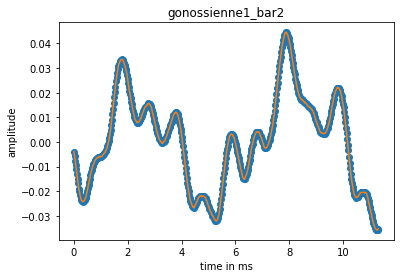

In [5]:
#plot the first 500 smaple points to get a sense of the data

n=500

x = np.arange(n)
x = x/sampling_rate*1000
y = samples[0:n]
plt.title(musicbar) 
plt.xlabel("time in ms") 
plt.ylabel("amplitude") 
plt.plot(x,y,"o") 
plt.plot(x,y)
plt.show()

In [6]:
#reduce the samples array to 2^n_qubits
n_qubits = 3 #number of qubits that will be used to encode samples in QFT
samples.resize((2**n_qubits,),refcheck=False)
print(samples.shape)
print(len(samples), sampling_rate)
print(samples.dtype)

(8,)
8 44100
float64


In [7]:
#play the original wav file
#Audio(file_path)

In [8]:
#Encodes a normalized set of amplitudes from the audio samples onto the states of the qubits
def create_encoded_qc(samples):
    amplitudes = len(samples)
    num_qubits = int(math.log2(amplitudes))
    
    q = QuantumRegister(num_qubits) 
    qc = QuantumCircuit(q)
    
    normalized_amplitudes = samples / np.linalg.norm(samples) 
    qc.initialize(normalized_amplitudes, [q[i] for i in range(num_qubits)]) 
    return qc

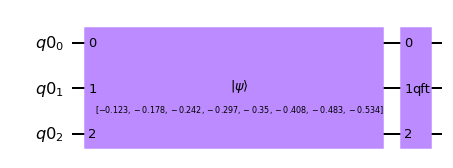

In [9]:
#Create Quantum Circuit and apply QFT
audio_qc = create_encoded_qc(samples)
audio_qc1 = audio_qc.compose(QFT(num_qubits=n_qubits, approximation_degree=0, do_swaps=True, inverse=False, insert_barriers=False, name='qft'))
audio_qc1.draw('mpl')

In [10]:
sv_backend = Aer.get_backend('statevector_simulator')
outsv = execute(audio_qc1, sv_backend).result().get_statevector()

a000 = outsv.data[0]
a001 = outsv.data[1]
a010 = outsv.data[2]
a011 = outsv.data[3]
a100 = outsv.data[4]
a101 = outsv.data[5]
a110 = outsv.data[6]
a111 = outsv.data[7]

heightsize = 1000
widthsize = 1000 # heightsize
escapeno = 2

def julia_set1_8CN(c0=a000, c1=a001, c2=a010, c3=a011, c4=a100, c5=a101, c6=a110, c7=a111, height=heightsize, width=widthsize, x=0, y=0, zoom=1, max_iterations=100): # zoom=0.7 # x=-1.5, y=0.4, zoom=1
    # To make navigation easier we calculate these values
    x_width = 1.5
    y_height = 1.5*height/width
    x_from = x - x_width/zoom
    x_to = x + x_width/zoom
    y_from = y - y_height/zoom
    y_to = y + y_height/zoom
    # Here the actual algorithm starts
    x = np.linspace(x_from, x_to, width).reshape((1, width))
    y = np.linspace(y_from, y_to, height).reshape((height, 1))
    z = x + 1j * y
    # Initialize z to all zero
    c0 = np.full(z.shape, c0)
    c1 = np.full(z.shape, c1)
    c2 = np.full(z.shape, c2)
    c3 = np.full(z.shape, c3)
    c4 = np.full(z.shape, c4)
    c5 = np.full(z.shape, c5)
    c6 = np.full(z.shape, c6)
    c7 = np.full(z.shape, c7)
    # To keep track in which iteration the point diverged
    div_time = np.zeros(z.shape, dtype=int)
    # To keep track on which points did not converge so far
    m = np.full(c0.shape, True, dtype=bool) 
    for i in range(max_iterations):
        z[m] = ((z[m]**4 + c6[m]*z[m]**3 + c4[m]*z[m]**2 + c2[m]*z[m] + c0[m]) / (z[m]**4 + c7[m]*z[m]**3 + c5[m]*z[m]**2 + c3[m]*z[m] + c1[m])) # julia set mating
        m[np.abs(z) > escapeno] = False 
        div_time[m] = i
    return div_time

def julia_set2_8CN(c0=a000, c1=a001, c2=a010, c3=a011, c4=a100, c5=a101, c6=a110, c7=a111, height=heightsize, width=widthsize, x=0, y=0, zoom=1, max_iterations=100):
    # To make navigation easier we calculate these values
    x_width = 1.5
    y_height = 1.5*height/width
    x_from = x - x_width/zoom
    x_to = x + x_width/zoom
    y_from = y - y_height/zoom
    y_to = y + y_height/zoom
    # Here the actual algorithm starts
    x = np.linspace(x_from, x_to, width).reshape((1, width))
    y = np.linspace(y_from, y_to, height).reshape((height, 1))
    z = x + 1j * y
    # Initialize z to all zero
    c0 = np.full(z.shape, c0)
    c1 = np.full(z.shape, c1)
    c2 = np.full(z.shape, c2)
    c3 = np.full(z.shape, c3)
    c4 = np.full(z.shape, c4)
    c5 = np.full(z.shape, c5)
    c6 = np.full(z.shape, c6)
    c7 = np.full(z.shape, c7)
    # To keep track in which iteration the point diverged
    div_time = np.zeros(z.shape, dtype=int)
    # To keep track on which points did not converge so far
    m = np.full(c0.shape, True, dtype=bool) 
    for i in range(max_iterations):
        z[m] = ((z[m]**8 + c6[m]*z[m]**7 + c4[m]*z[m]**6 + z[m]**4 + c2[m]*z[m]**3 + z[m]**2 + c0[m]) / (z[m]**8 + c7[m]*z[m]**7 + c5[m]*z[m]**6 + z[m]**4 + c3[m]*z[m]**3 + z[m]**2 + c1[m])) # julia set mating
        m[np.abs(z) > escapeno] = False 
        div_time[m] = i
    return div_time

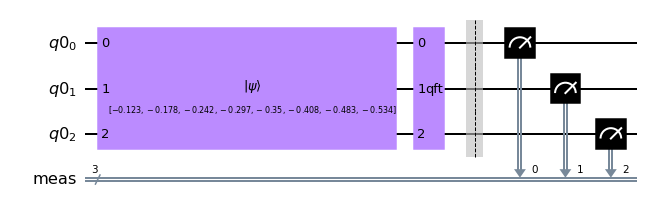

In [11]:
# Add measurements
audio_qc1.measure_all()
audio_qc1.draw('mpl')

In [12]:
# Build noise model from backend properties
provider = IBMQ.load_account()
backendqc = provider.get_backend('ibmq_lima') 
noise_model = NoiseModel.from_backend(backendqc)

# Get coupling map from backend
coupling_map = backendqc.configuration().coupling_map

# Get basis gates from noise model
basis_gates = noise_model.basis_gates

Return only frequencies that are below the Nyquist limit of half the sample size https://en.wikipedia.org/wiki/Nyquist_frequency

For example, audio CDs have a sampling rate of 44100 samples/sec. The Nyquist frequency is therefore 22050 Hz


{'010': 19, '000': 791, '001': 63, '111': 47, '100': 39, '101': 24, '110': 26, '011': 15}


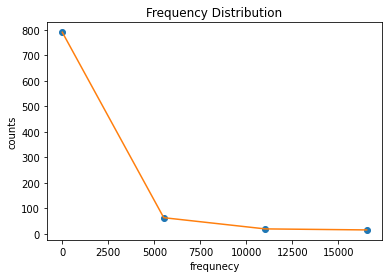

In [13]:
shotno=1024
job_ibmq = execute(audio_qc1, Aer.get_backend('qasm_simulator'),
                   coupling_map=coupling_map,
                   basis_gates=basis_gates,
                   noise_model=noise_model, shots=shotno)
resultqc = job_ibmq.result()

counts = resultqc.get_counts(audio_qc1)
print(counts)

fft = get_fft_from_counts(counts, n_qubits)[:samples.size//2]
plot_samples(fft,sampling_rate/samples.size) 

### Perform calculations and plot the fractals

In [14]:
# Get the state vector probabilities
prob000statevec = outsv.probabilities()[0]
prob001statevec = outsv.probabilities()[1]
prob010statevec = outsv.probabilities()[2]
prob011statevec = outsv.probabilities()[3]
prob100statevec = outsv.probabilities()[4]
prob101statevec = outsv.probabilities()[5]
prob110statevec = outsv.probabilities()[6]
prob111statevec = outsv.probabilities()[7]

# Calculate the probabilities for each basis state based on the count results
prob000qc = counts['000']/shotno
prob001qc = counts['001']/shotno
prob010qc = counts['010']/shotno
prob011qc = counts['011']/shotno
prob100qc = counts['100']/shotno
prob101qc = counts['101']/shotno
prob110qc = counts['110']/shotno
prob111qc = counts['111']/shotno

# One simple approach to obtain the modified state vector basis states # amplitude^2 = probability
a000qc = a000*np.sqrt(prob000qc/prob000statevec)
a001qc = a001*np.sqrt(prob001qc/prob001statevec)
a010qc = a010*np.sqrt(prob010qc/prob010statevec)
a011qc = a011*np.sqrt(prob011qc/prob011statevec)
a100qc = a100*np.sqrt(prob100qc/prob100statevec)
a101qc = a101*np.sqrt(prob101qc/prob101statevec)
a110qc = a110*np.sqrt(prob110qc/prob110statevec)
a111qc = a111*np.sqrt(prob111qc/prob111statevec)

(-0.5, 999.5, 999.5, -0.5)

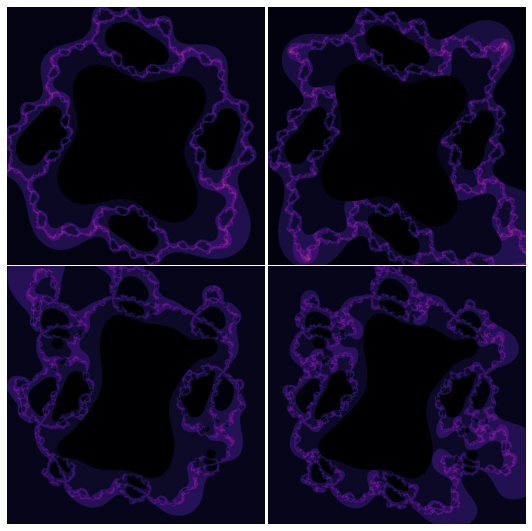

In [15]:
fig = plt.figure(figsize=(12, 12)) 

gs = gridspec.GridSpec(2, 2, width_ratios=[1,1],
         wspace=0.01, hspace=0.0, 
         top=0.8, bottom=0.2, 
         left=0.2, right=0.8) 

ax = plt.subplot(gs[0,0])
ax.imshow(julia_set1_8CN(c0=a000, c1=a001, c2=a010, c3=a011, c4=a100, c5=a101, c6=a110, c7=a111), cmap='magma')
ax.axis('off')
ax = plt.subplot(gs[0,1])
ax.imshow(julia_set1_8CN(c0=a000qc, c1=a001qc, c2=a010qc, c3=a011qc, c4=a100qc, c5=a101qc, c6=a110qc, c7=a111qc), cmap='magma')
ax.axis('off')
ax = plt.subplot(gs[1,0])
ax.imshow(julia_set2_8CN(c0=a000, c1=a001, c2=a010, c3=a011, c4=a100, c5=a101, c6=a110, c7=a111), cmap='magma')
ax.axis('off')
ax = plt.subplot(gs[1,1])
ax.imshow(julia_set2_8CN(c0=a000qc, c1=a001qc, c2=a010qc, c3=a011qc, c4=a100qc, c5=a101qc, c6=a110qc, c7=a111qc), cmap='magma')
ax.axis('off')

#plt.savefig('plots/QFT_3qubits_4fractals_without_and_with_noisemodel_simulator_' + str(musicbar) + '.png', dpi=300) 